# Изучение закономерностей, определяющих успешность игр

В нашем распоряжении данные интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

**Цель:** необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**План работы:**
1. Загрузить данные
2. Провести предобработку данных
3. Провести исследовательский анализ данных
4. Составить портрет пользователя каждого региона
5. Проверить гипотезы
6. Написать общий вывод

**Описание данных:**
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Изучим общую информацию о данных.

#### Импортируем необходимые библиотеки pandas. Считаем данные из csv-файла в датафрейм и сохраните в переменную data.

In [3]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [4]:
data = pd.read_csv('/datasets/games.csv', sep=',')
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


#### Выведем основную информацию о датафрейме с помощью метода info().

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Изучив общую информацию по датафрейму, мы видим:**
- количество записей - 16715
- пропущенные значения (NaN)
- неверные типы данных

### Предобработка данных.

#### Приведём к нижнему регистру названия столбцов:

In [6]:
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Обработаем пропуски:

In [7]:
# Выведем пропуски в каждом столбце в порядке возрастания их количества
data.isna().sum().sort_values()

platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
name                  2
genre                 2
year_of_release     269
user_score         6701
rating             6766
critic_score       8578
dtype: int64

Посмотрим на долю пропусков, и в дальнейшем, на основании этого, примем решение о удалении, замене либо игнорировании пропусков:

In [8]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


##### Пропуски в столбцах name и genre.
Видно, что в двух столбцах **name** и **genre** всего по 2 пропуска (в процентах это даже никак не отображается), так как их такое малое количество, их можно исключить, заменив на пустые строки:

In [9]:
# Удаляем пропуски в этих столбцах:
data.dropna(subset=['name'], inplace=True)
data.dropna(subset=['genre'], inplace=True)
data.isna().sum().sort_values()

name                  0
platform              0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
year_of_release     269
user_score         6699
rating             6764
critic_score       8576
dtype: int64

**Причина пропусков:**

Возможно слишком сложное название игры, поэтому не заполнили этот параметр, также человек мог не знать жанра игры, поэтому оставил значение пустым.

##### Пропуски в столбце year_of_release.
Рассмотрим столбец year_of_release, выявим причину пропусков:

In [10]:
data['year_of_release'].value_counts(dropna=False)

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
NaN        269
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1983.0      17
1989.0      17
1990.0      16
1987.0      16
1988.0      15
1984.0      14
1985.0      14
1980.0       9
Name: year_of_release, dtype: int64

**Причина пропусков:**

Год могли не указать, потому что не знали год выпуска той или иной игры, либо забыли это сделать, поэтому появилось такое количество пропущенных значений (269 значений NaN).

В любом случае, нам будет сложно для каждой игры находить год выпуска, можно попробовать вытащить год из названия игры, но это может привести к неправильному нахождению точного года вывпуска игры, поэтому мы заменим эти значения пустыми строками. Также 269 значений от 16715 это 1,6%, мы потеряем не так много данных.  

In [11]:
# Удаляем пропуски в столбце с годом:
data.dropna(subset=['year_of_release'], inplace=True)

##### Пропуски в столбцах user_score, rating, critic_score.

У нас осталось три столбца с большим количеством пропусков пропусками: **user_score - 6607, rating - 6678, critic_score - 8463** - оценка пользователей, рейтинг от организации ESRB, оценка критиков соответственно. В таком случае просто удалить значения нельзя, но и логичной замены подобрать нельзя. Если мы сможем **user_score** и **critic_score** заполнить нолями, то в дальнейшем это отразится на анализе данных. Самый лучший вариант оставить пропуски.

**Причины пропусков:** пользователь не захотел оставлять свою оценку, данной игре не удалось присвоить возрастную категорию от организации ESRB, критики не успели оценить эту игру.

In [12]:
data.isna().sum().sort_values()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
user_score         6605
rating             6676
critic_score       8461
dtype: int64

In [13]:
data['rating'].fillna('Unknown', inplace=True)
data.isna().sum().sort_values()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
rating                0
user_score         6605
critic_score       8461
dtype: int64

##### Аббревиатура 'tbd' в столбце с оценкой пользователей. 

В столбце с оценкой пользователей **user_score** можно увидеть аббревиатуру **tbd**.

In [14]:
data['user_score'].value_counts(dropna=False)

NaN    6605
tbd    2376
7.8     322
8       285
8.2     276
       ... 
1.1       2
1.5       2
0.6       2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64

**TDB (To Be Determined)** — это аббревиатура, которая переводится с английского как «будет определено». В контексте этих даных, это означает, что пока не принято окончательное решение или установлено конкретное значение рейтинга. Возможно на эту игру не было отзывов, либо их малое количество.

In [15]:
#Заменим значение "tbd" на NaN
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'].value_counts(dropna=False)

NaN    8981
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
1.5       2
0.6       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

#### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец 'total_sales'.

In [16]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['other_sales'] + data['jp_sales']
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,Unknown,0.01


Мы получили дополнительный столбец в датафрейме, в котором содержится сумма от продаж по всем регионам для каждой игры.

#### Преобразуем типы данных в столбцах, где это необходимо:

In [17]:
# Заменим тип данных в столбце year_of_release с float64 на int64:
data['year_of_release'] = data['year_of_release'].astype('int')

# Оценка пользователей может быть не целым числом, поэтому тип object заменяем на float64:
data['user_score'] = data['user_score'].astype('float')

# Замена типа данных с float64 на float32 для экономии памяти:
data['user_score'] = data['user_score'].astype('float32')
data['na_sales'] = data['na_sales'].astype('float32')
data['eu_sales'] = data['eu_sales'].astype('float32')
data['jp_sales'] = data['jp_sales'].astype('float32')
data['other_sales'] = data['other_sales'].astype('float32')
data['critic_score'] = data['critic_score'].astype('float32')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       7463 non-null   float32
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float32(6), float64(1), int64(1), object(4)
memory usage: 1.3+ MB


Итоги преобразования типа данных:
- Год **year_of_release** лучше всего представить в целлочисленном типе, поэтому мы привели значения к типу данных **Int64**. 
- Оценка пользователей **user_score** может быть представлена и не в целом виде, поэтому поменяли тип данных с object на float32.
- Заменили типы данных с float64 на float32 для экономии памяти.

#### Проверим данные на наличие дубликатов.

In [19]:
# Проверка на наличие явных дубликатов:
data.duplicated().sum()

0

In [20]:
# Проведём проверку на дубликаты, основываясь на столбцах 'name', 'platform' и 'year_of_release':
columns_to_check = ['name', 'platform', 'year_of_release']
data[data.duplicated(subset=columns_to_check, keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E,0.01


In [21]:
# Удалим строку с индексом 16230:
data = data.drop_duplicates(subset=columns_to_check, keep='first')
data.loc[(data['name'] == 'Madden NFL 13') & (data['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56


Таким образом, мы выдим, что явные дубликаты отсутствуют. Проверили столбцы 'name', 'platform' и 'year_of_release' на наличие неявных дубликатов, поняли, что их всего одна пара, поэтому удалили повтор.

#### Краткий вывод по предобработке данных:

* Привели к нижнему регистру названия столбцов.
* Пропуски в столбцах **name** и **genre** исключили, заменив на пустые строки. *Причиной пропусков* было то, что слишком сложное было название игры, поэтому не заполнили этот параметр, также человек мог не знать жанра игры, поэтому оставил значение пустым.
* Пропуски в столбце **year_of_release** мы удалили, всего их было - **269** (это **1,6%** от общего объёма данных). *Причина пропусков*: год могли не указать, потому что не знали год выпуска той или иной игры, либо забыли это сделать, поэтому появилось такое количество пропущенных значений.
* Пропуски в столбцах **user_score** = **6607**, **rating** = **6678**, **critic_score** = **8463**. В таком случае просто удалить значения нельзя, но и логичной замены подобрать нельзя. Самый лучший вариант оставить пропуски. Но в колонке 'rating' заменила все пропущенные значения на 'Unknown' = "Неизвестный", так как система рейтинга ESRB была основана только в 1994 году, а некоторые игры выпускались раньше. *Причины пропусков*: пользователь не захотел оставлять свою оценку, данной игре не удалось присвоить возрастную категорию от организации ESRB, критики не успели оценить эту игру. 
* Заменили значение **"tbd" на NaN**.
* Мы получили дополнительный столбец в датафрейме - **total_sales**, в котором содержится сумма от продаж по всем регионам для каждой игры. 
* Год **year_of_release** лучше всего представить в целлочисленном типе, поэтому мы привели значения к типу данных **Int64**.
* Оценка пользователей user_score может быть представлена и не в целом виде, поэтому поменяли тип данных с **object** на **float32**.
* Заменили типы данных с **float64** на **float32** для экономии памяти.
* Проработали явные и неявные дубликаты, первых не обнаружилось. Неявных дубликатов выявили только одну пару, это две строки (одинаковое в этих строках всё, кроме количества продаж в регионах), одну из строк, которая несла в себе мало информации, я удалила.


По итогу предобработки у нас осталось **16443**  строки - это **98,4%** от общего объёма данных (**16715** строк).

### Проведём исследовательский анализ данных.

#### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [22]:
# Построим сводную таблицу, в которой будет количество видеоигр, выпущенных в определённый год:
games_for_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
games_for_year.head(10)

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


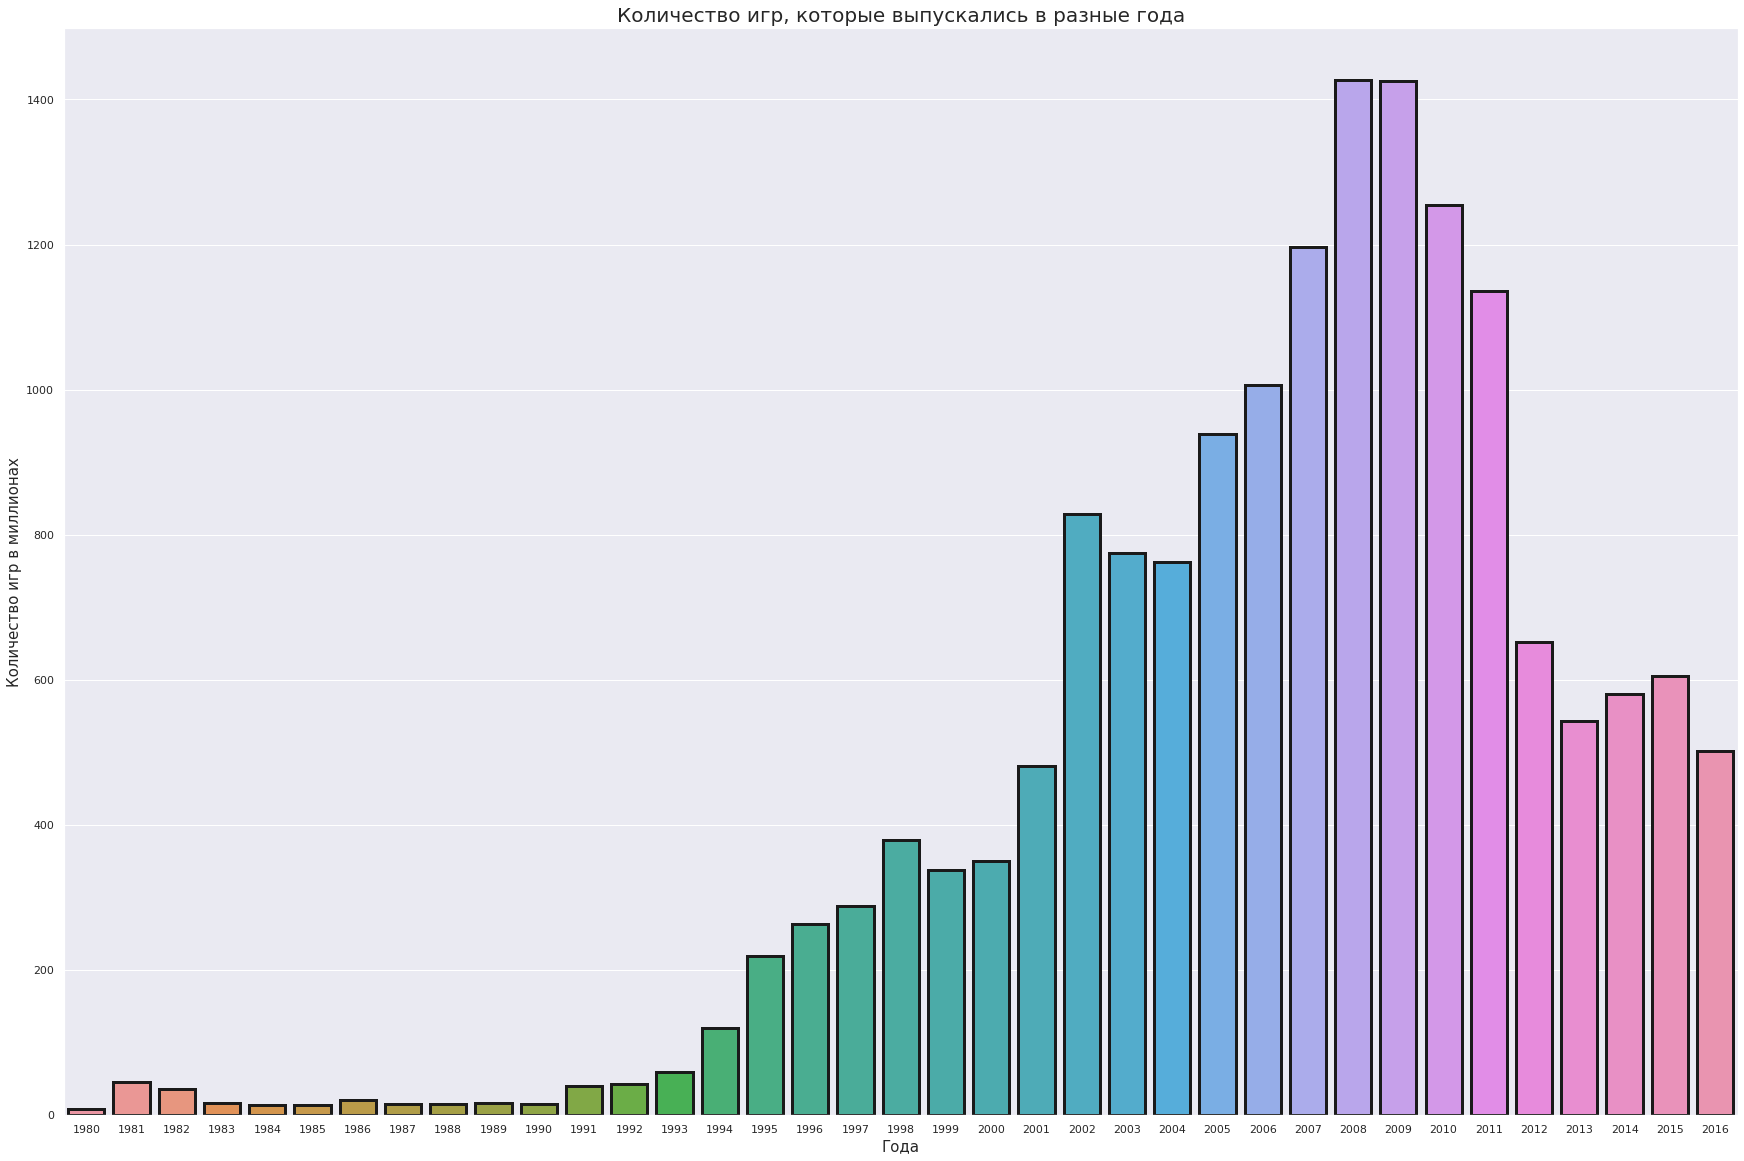

In [23]:
# Для визуализации данных построим столбчатую диаграмму:
sns.set()
plt.figure(figsize = (30,20))
 
sns.barplot(x = 'year_of_release', y = 'name', 
           data = games_for_year, linestyle = "-", linewidth = 3,
           edgecolor = "k")
 
plt.title("Количество игр, которые выпускались в разные года", fontsize = 20)
plt.xlabel("Года", fontsize = 15)
plt.ylabel("Количество игр в миллионах", fontsize = 15)
 
plt.show()

* По графику мы видим, что до **1991** года выпускалось **малое количество**, так как не у многих людей были компьютеры, следовательно, не было смысла выпускать большие партии игр, также не было достаточно возможностей для создания качественных игр, не хватало мощности компьютеров. 
* В **1998** году видно **скачок** по количеству выпускаемых игр до этого. Возможно, выпустилась игра, которую все очень ждали, она стала популярна и хорошо продавалась.
* К **2002** году компьютеры всё больше и больше появлялись в домах, выходили новые игры, поэтому люди больше стали играть и покупать необходимое оборудование для этого.
* **2008-2009** период огромного количества выпуска игр, по графику мы видим, что эти года являются **пиками роста** выпускаемых игр. Это время выхода огромного количества на любой вкус различных видеоигр.
* С **2010** и далее происходит **спад** выпускаемых видеоигр, можно предположить, что причиной этого могло послужить развитие мобильных устройств.

#### Посмотрим, как менялись продажи по платформам. 
Для этого выберем топ 15 популярных платформ с наибольшими суммарными продажами и построим распределение по годам.

In [24]:
# Мы создаём сводную таблицу grouped_platform, в которой группируем данные по столбцу 
# platform и суммируем значения столбца total_sales для каждой платформы. 
# Затем мы сортируем эту таблицу по убыванию общих продаж.
grouped_platforms = data.pivot_table(index='platform',
                                    values='total_sales', 
                                    aggfunc='sum').sort_values(by='total_sales', ascending=False)
grouped_platforms = grouped_platforms.head(15).reset_index()
grouped_platforms

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


In [25]:
# Теперь создаем переменную top, которая будет содержать список из 15 наиболее 
# прибыльных платформ, отсортированных по убыванию общих продаж.
top15 = data.groupby('platform')['total_sales'].sum().nlargest(15).index
top15

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS',
       'PC', 'GB', 'XB', 'NES', 'N64'],
      dtype='object', name='platform')

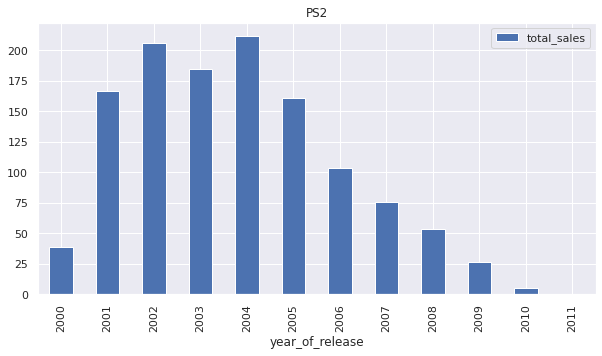

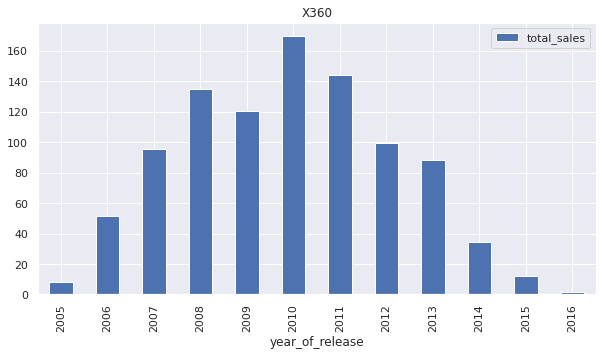

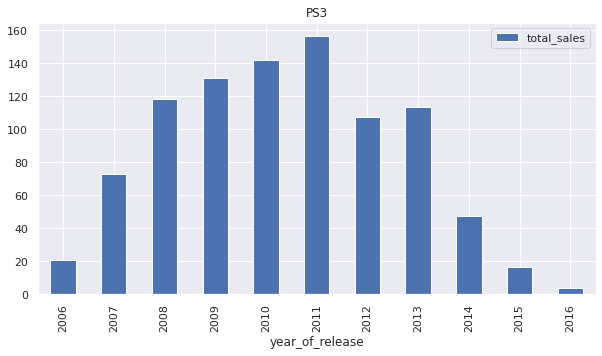

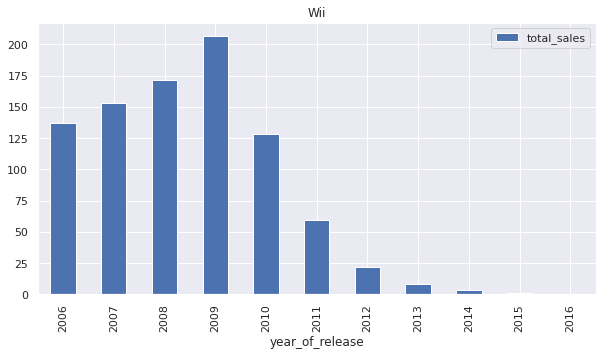

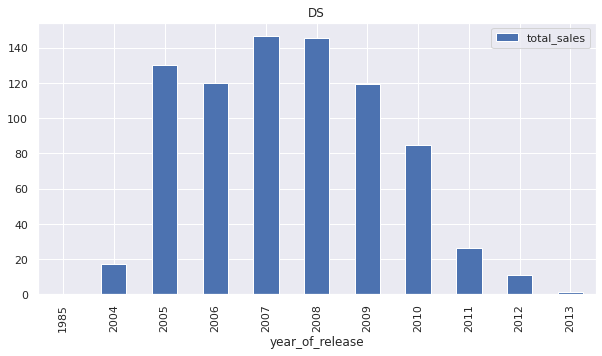

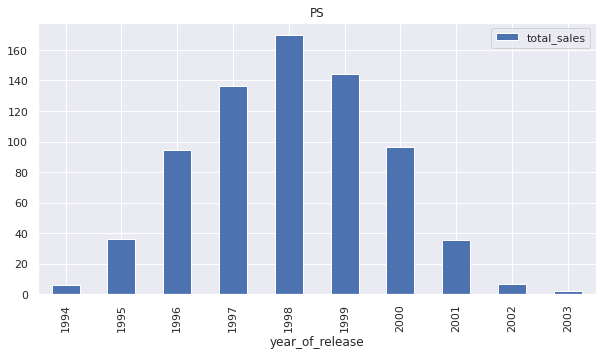

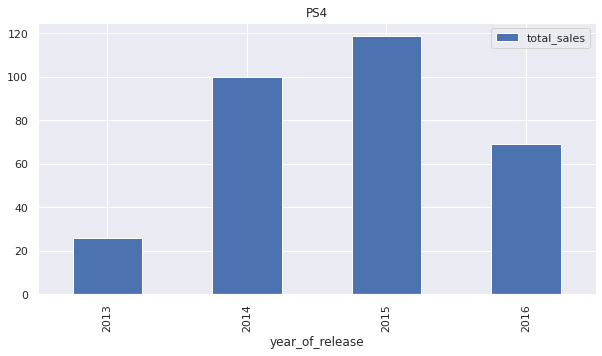

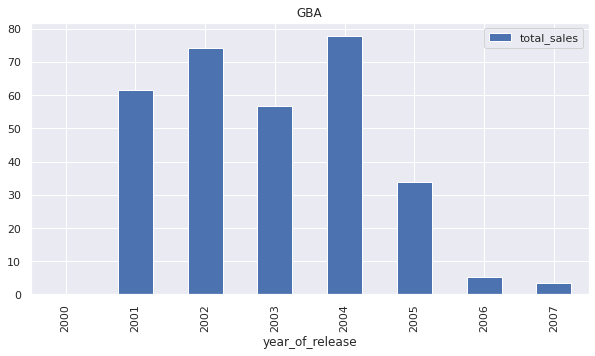

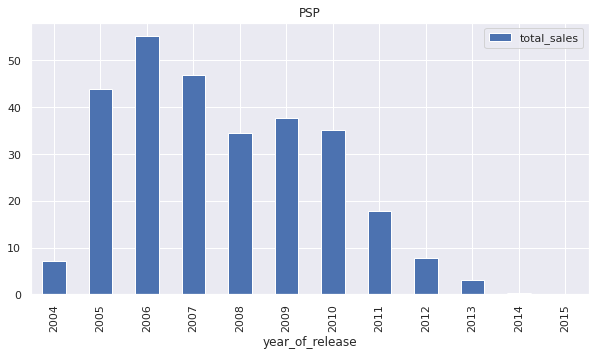

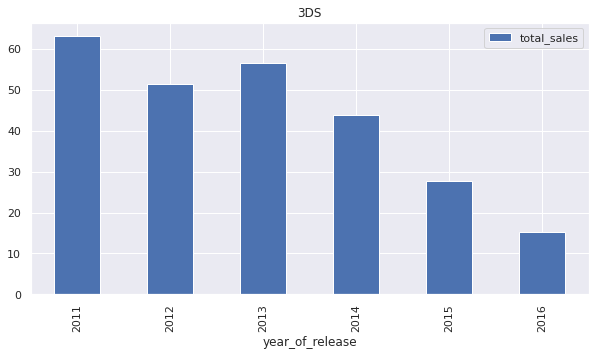

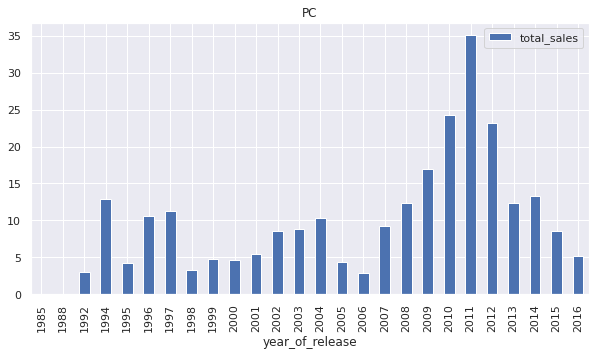

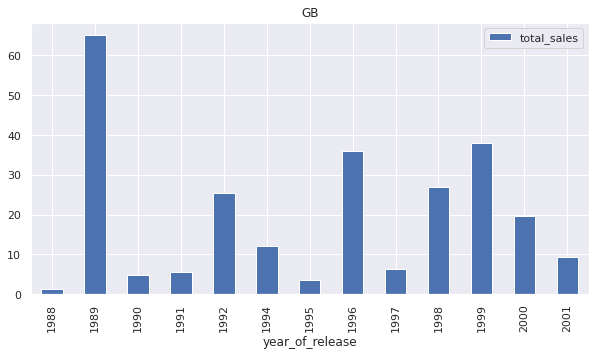

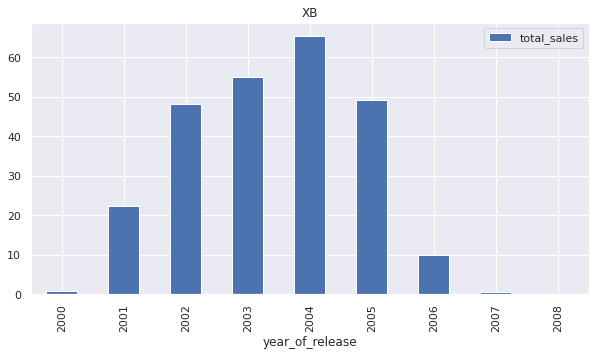

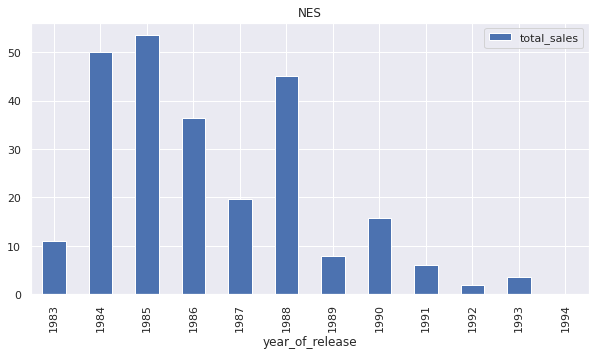

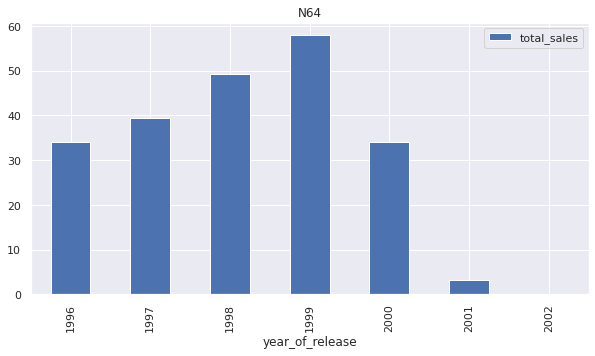

In [26]:
for platform in top15:
    data[data['platform'] == platform].pivot_table(index='year_of_release', 
                                                   values='total_sales', 
                                                   aggfunc='sum').plot(kind='bar', figsize=(10,5))
    plt.title(platform)

Рассмотрим первые 5 лидеров, чтобы понять, за какой характерный срок появляются новые и исчезают старые платформы.
* **PS2:** пик её популярности виден с 2001 по 2005 год, затем продажи падают и 2011 году практически прекращаются. Можно считать, что 10 лет существовала данная платформа.
* **X360:** 2006-2010 год расцвет данной платформы, затем её продажи падают, к 2016 году у неё минимальные продажи. Она существовала также 10 лет.
* **PS3** в 2007 году набирает популярность, в 2011 году пик её продаж, далее идёт спад, в 2016 году про неё практически уже забфли. Существовала 9 лет.
* **Wii:** с 2006 по 2009 была очень популярна и продаваема, затем продажи уменьшаются. 2016 год считается её последним. Срок её существования - 10 лет.
* **DS:** в 1985 году начались продажи, но их практически не было, в 2004 году небольшой рост продаж, в 2005 резкий скачок продаввемости, 2007 и 2008 - пик популярности данной платформы. К 2013 году она теряется практически полностью свою популярность. Существовала 9 лет. 

Пронаблюдав 5 самых популярных платформ, мы выяснили, что средний срок их существования примерно 10 лет. 

#### Возьмём данные за соответствующий актуальный период. 

Так как мы выяснили, что платформы существуют примерно 10 лет, то логичней будет взять такой период, чтобы он захватывал 2017 год, так как эти данные помогут построить прогноз на этот год.

Актуальный период - **с 2012 по 2016**. 2011 год, как мы видели на диаграмме выше ("Количество игр, которые выпускались в разные года"), это последний год высокой популярности платформ, в 2012 году был спад, а в следующие года продажи находились примерно на одном уровне, поэтому я считаю, что нужно взять именно этот период. Так мы сможем выбрать основную информацию для дальнейшего анализа.


In [27]:
# Сделаем срез данных по этому периоду:
period = data.query('year_of_release >= 2012')
period

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01


#### Выделим лидеров по продажам. 

In [28]:
# Отсортируем платформы по продажам:
platforms_leading = period.pivot_table(index='platform',
                                    values='total_sales', 
                                    aggfunc='sum').sort_values(by='total_sales', ascending=False)
platforms_leading = platforms_leading.reset_index()
platforms_leading

,platform,total_sales
0,PS4,314.14
1,PS3,288.78
2,X360,236.54
3,3DS,194.61
4,XOne,159.32
5,WiiU,82.19
6,PC,62.65
7,PSV,49.18
8,Wii,35.37
9,DS,12.55


In [29]:
# Теперь создаем переменную top11, которая будет содержать список из 11 наиболее 
# прибыльных платформ, отсортированных по убыванию общих продаж.
top11 = period.groupby('platform')['total_sales'].sum().nlargest(11).index
top11

Index(['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS',
       'PSP'],
      dtype='object', name='platform')

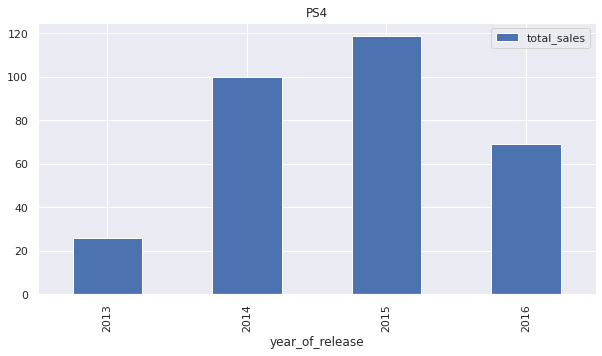

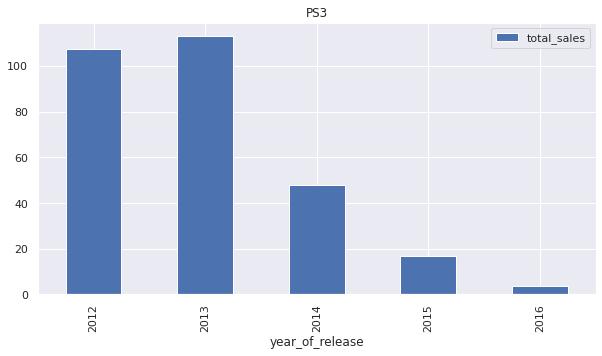

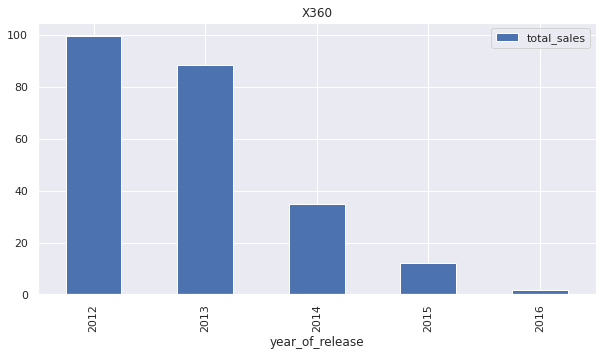

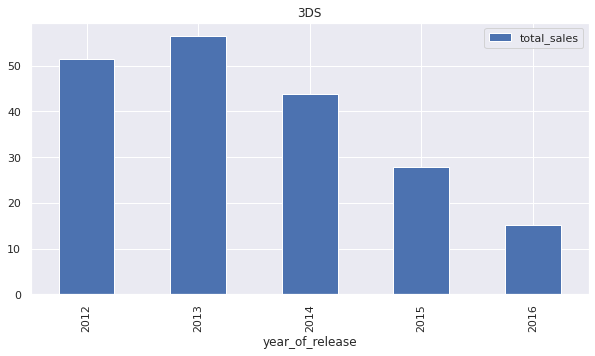

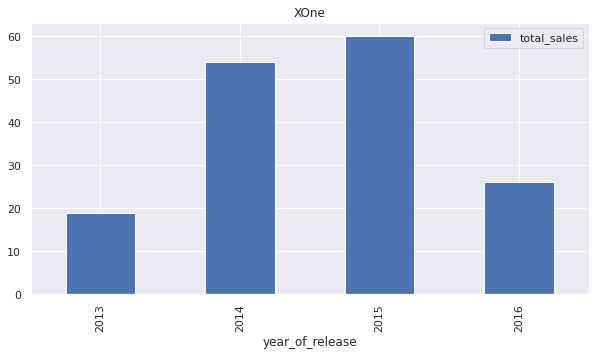

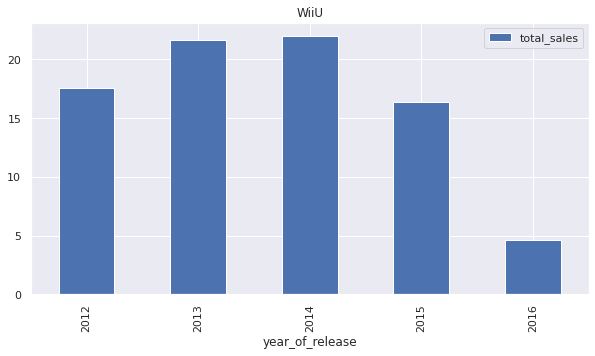

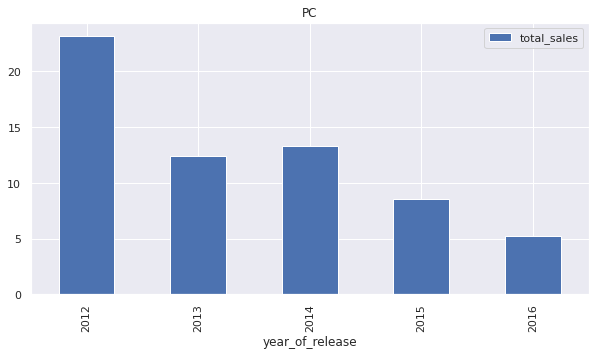

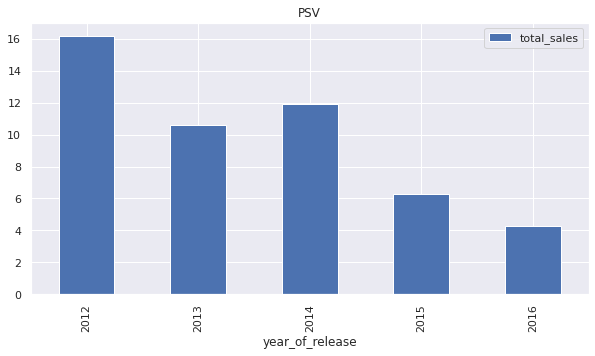

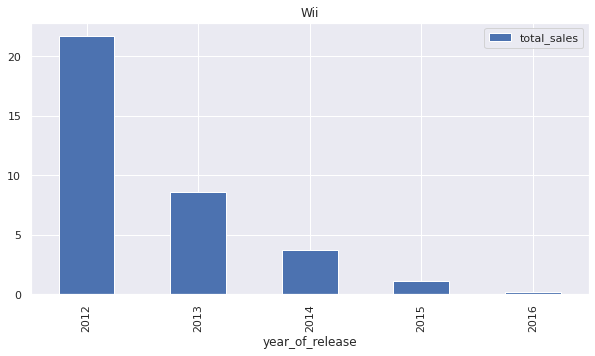

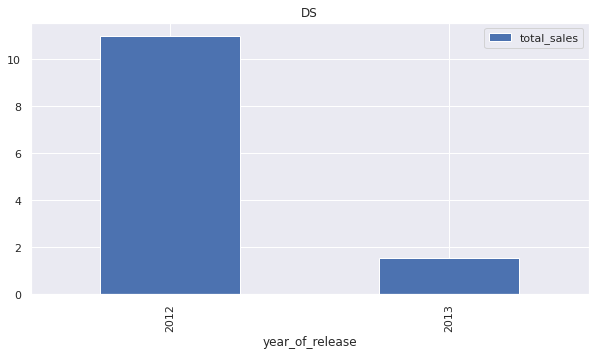

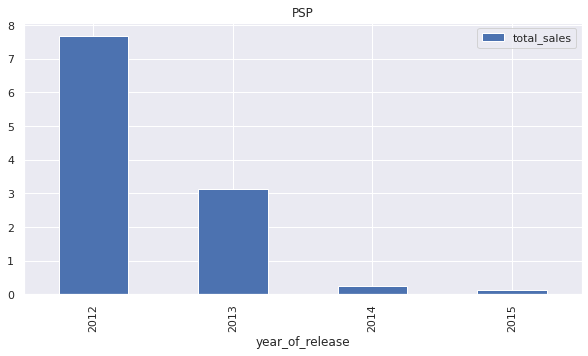

In [30]:
# Визуализируем данные, чтобы понять, падают или растут продажи от данных платформ:
for platforms in top11:
    period[period['platform'] == platforms].pivot_table(index='year_of_release', 
                                                   values='total_sales', 
                                                   aggfunc='sum').plot(kind='bar', figsize=(10,5))
    plt.title(platforms)

Платформы: **PS4, 3DS, XOne, WiiU, PC, PSV**, на мой взгляд, являются потенциально прибыльными, так как к 2016 они, в отличие отостальных, ещё хорошо продаются на рынке. Также, можно учитывать, что данные за 2016 год неполные.

Таким образом для дальнейшего анализа у нас остались **6 платформ**.

#### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

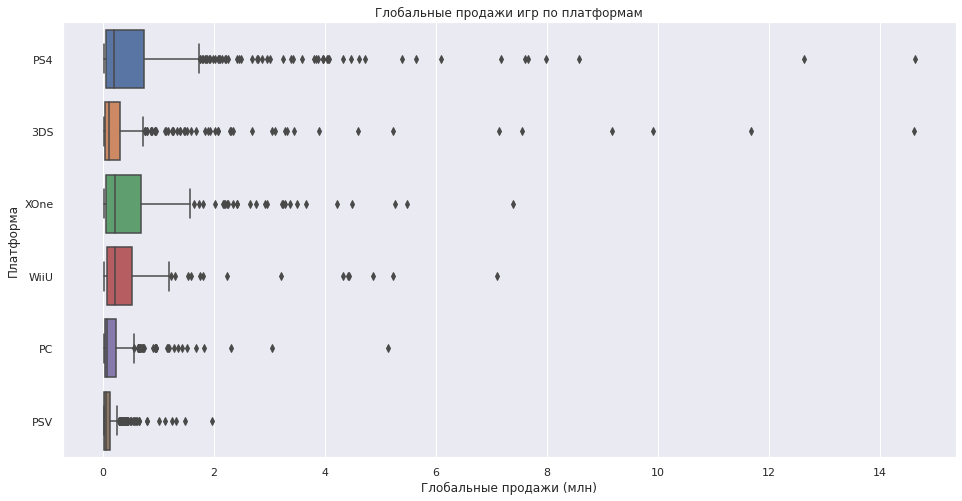

In [31]:
# Список платформ, для которых мы будем строить график:
platforms = ['PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']

# Фильтрация данных по выбранным платформам:
filtered_data = period[period['platform'].isin(platforms)]

# Создание ящика с усами с использованием:
plt.figure(figsize=(16, 8))
sns.boxplot(x='total_sales', y='platform', data=filtered_data)
plt.title('Глобальные продажи игр по платформам')
plt.xlabel('Глобальные продажи (млн)')
plt.ylabel('Платформа')

# Отображение графика
plt.show()

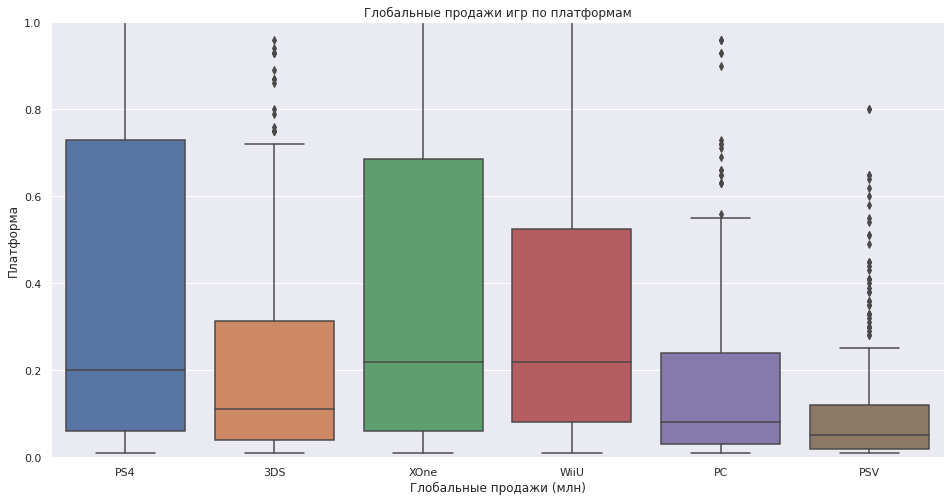

In [32]:
# Создание ящика с усами , на котором будут видны медианы и квартили:
plt.figure(figsize=(16, 8))
sns.boxplot(x='platform', y='total_sales', data=filtered_data)
plt.title('Глобальные продажи игр по платформам')
plt.xlabel('Глобальные продажи (млн)')
plt.ylabel('Платформа')
plt.ylim(0,1)

# Отображение графика
plt.show()

In [33]:
# Зафиксируем показания диаграммы, для этого посмотрим на числовое описание данных:
filtered_data.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.04,0.11,0.3125,14.60
PC,250.0,0.250600,0.494640,0.01,0.03,0.08,0.2400,5.14
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.7300,14.63
PSV,411.0,0.119659,0.203011,0.01,0.02,0.05,0.1200,1.96
WiiU,147.0,0.559116,1.058836,0.01,0.08,0.22,0.5250,7.09
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.6850,7.39


Вывод:
- На первом месте по медианным значениям продажи больше всего у платформ XOne и WiiU, далее идёт - PS4, 3DS, на предпоследнем и последнем местах - PC и PSV соотвветственно. 
- На графике "ящик с усами" мы видим большое количество выбросов практически у всех платформ. Это можно наблюдать из-за того, что какие игры были очень популярными, их очень много продавали. 

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
Для этого построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Для анализа возьмём самую популярную платформу - PS4.

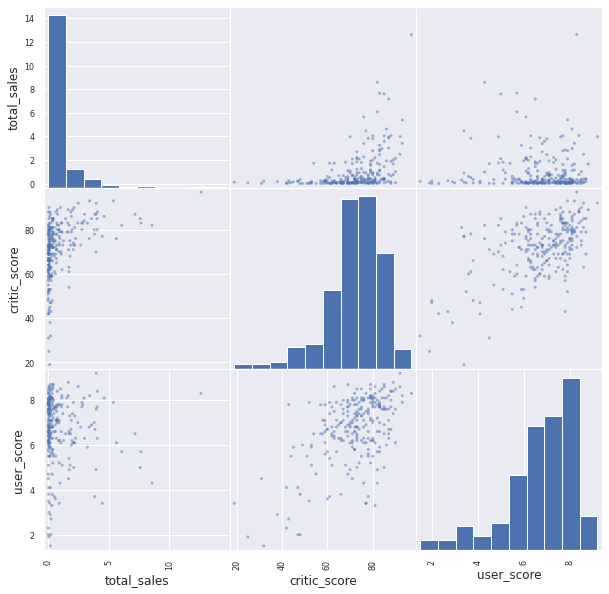

In [34]:
# Строим матрицу диаграмм рассеяния:
pd.plotting.scatter_matrix(period[period['platform'] == "PS4"]
                           [['total_sales', 'critic_score', 'user_score']],
                           grid=True, 
                           figsize=(10, 10), 
                           alpha=0.5)
plt.show()

In [35]:
print('Корреляция между отзывами и продажами на платформе PS4:','\n')
filtered_data[filtered_data['platform'] == 'PS4'][['total_sales', 'critic_score', 'user_score']].corr()

Корреляция между отзывами и продажами на платформе PS4: 



,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


Вывод:
* Корреляция между отзывами критиков **critic_score** и продажами **total_sales** прослеживается, но не сильно (коэффициент равен **0.4**). Как и подразумевается, чем лучше оценка игры, тем больше продажи.
* Корреляция между отзывами пользователей **user_score** и продажами **total_sales** не прослеживается, а коэффициент равен **-0.03**. Можно увидеть на диаграмме рассеяния, что оценка за игру от пользователя низкая, а продажи от этой игры большие, поэтому коэффициент корреляции и отрицательный.

#### Соотнесём выводы с продажами игр на других платформах.

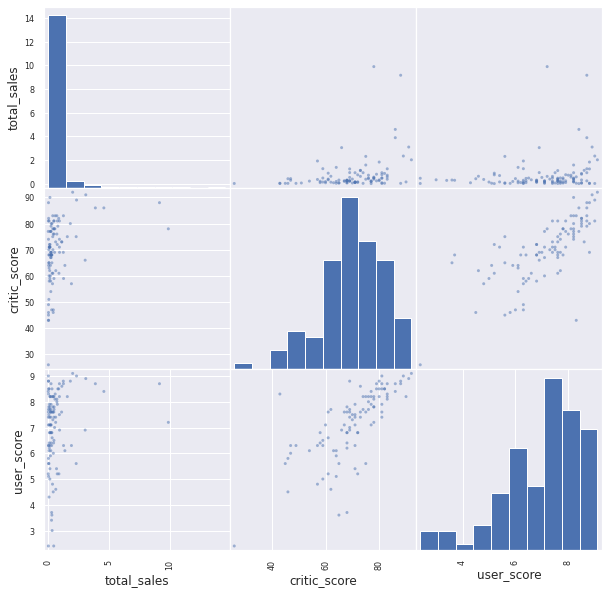

Корреляция между отзывами и продажами на платформе 3DS: 



,total_sales,critic_score,user_score
total_sales,1.000000,0.320803,0.197583
critic_score,0.320803,1.000000,0.722762
user_score,0.197583,0.722762,1.000000


In [36]:
# Строим матрицу диаграмм рассеяния:
pd.plotting.scatter_matrix(period[period['platform'] == "3DS"]
                           [['total_sales', 'critic_score', 'user_score']],
                           grid=True, 
                           figsize=(10, 10), 
                           alpha=0.5)
plt.show()
print('Корреляция между отзывами и продажами на платформе 3DS:','\n')
filtered_data[filtered_data['platform'] == '3DS'][['total_sales', 'critic_score', 'user_score']].corr()

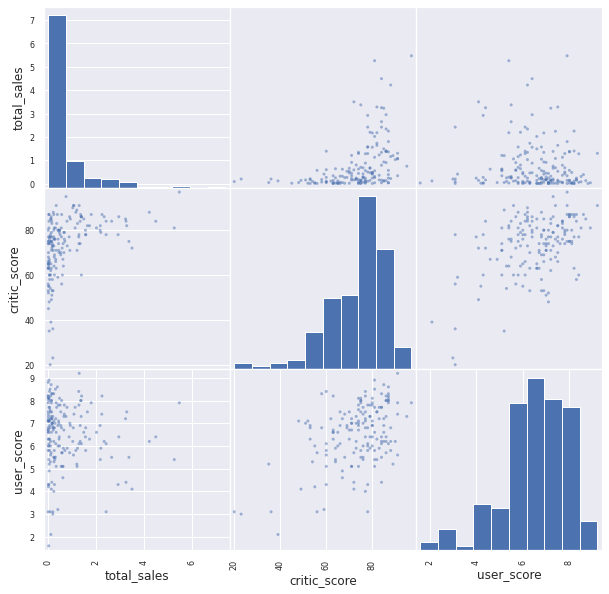

Корреляция между отзывами и продажами на платформе XOne: 



,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


In [37]:
# Строим матрицу диаграмм рассеяния:
pd.plotting.scatter_matrix(period[period['platform'] == "XOne"]
                           [['total_sales', 'critic_score', 'user_score']],
                           grid=True, 
                           figsize=(10, 10), 
                           alpha=0.5)
plt.show()
print('Корреляция между отзывами и продажами на платформе XOne:','\n')
filtered_data[filtered_data['platform'] == 'XOne'][['total_sales', 'critic_score', 'user_score']].corr()

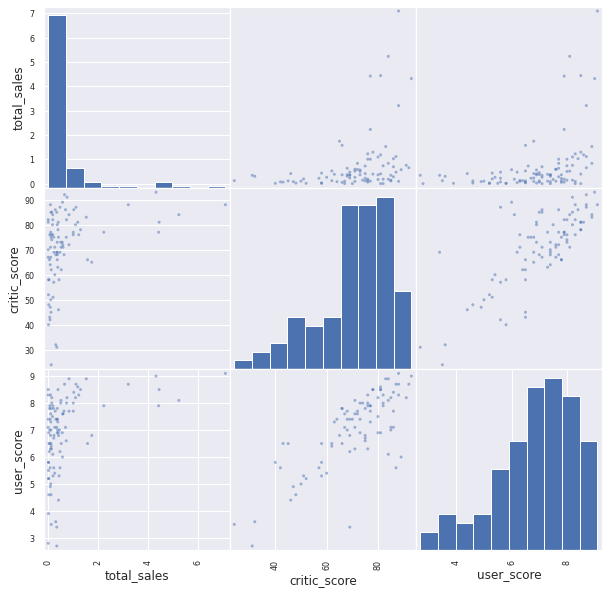

Корреляция между отзывами и продажами на платформе WiiU: 



,total_sales,critic_score,user_score
total_sales,1.000000,0.34838,0.400219
critic_score,0.348380,1.00000,0.770080
user_score,0.400219,0.77008,1.000000


In [38]:
# Строим матрицу диаграмм рассеяния:
pd.plotting.scatter_matrix(period[period['platform'] == "WiiU"]
                           [['total_sales', 'critic_score', 'user_score']],
                           grid=True, 
                           figsize=(10, 10), 
                           alpha=0.5)
plt.show()
print('Корреляция между отзывами и продажами на платформе WiiU:','\n')
filtered_data[filtered_data['platform'] == 'WiiU'][['total_sales', 'critic_score', 'user_score']].corr()

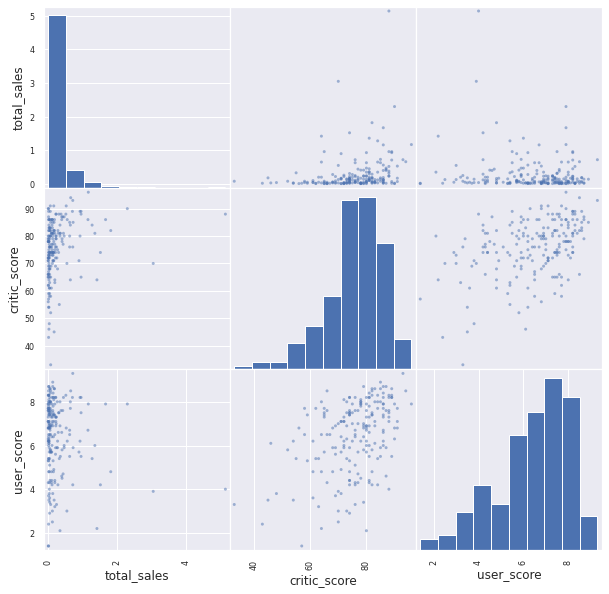

Корреляция между отзывами и продажами на платформе PC: 



,total_sales,critic_score,user_score
total_sales,1.000000,0.237243,-0.121867
critic_score,0.237243,1.000000,0.432587
user_score,-0.121867,0.432587,1.000000


In [39]:
# Строим матрицу диаграмм рассеяния:
pd.plotting.scatter_matrix(period[period['platform'] == "PC"]
                           [['total_sales', 'critic_score', 'user_score']],
                           grid=True, 
                           figsize=(10, 10), 
                           alpha=0.5)
plt.show()
print('Корреляция между отзывами и продажами на платформе PC:','\n')
filtered_data[filtered_data['platform'] == 'PC'][['total_sales', 'critic_score', 'user_score']].corr()

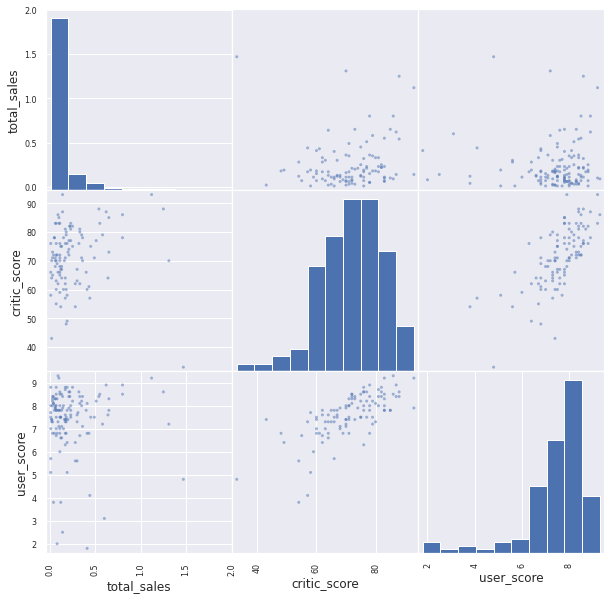

Корреляция между отзывами и продажами на платформе PSV: 



,total_sales,critic_score,user_score
total_sales,1.000000,0.094488,-0.004339
critic_score,0.094488,1.000000,0.699199
user_score,-0.004339,0.699199,1.000000


In [40]:
# Строим матрицу диаграмм рассеяния:
pd.plotting.scatter_matrix(period[period['platform'] == "PSV"]
                           [['total_sales', 'critic_score', 'user_score']],
                           grid=True, 
                           figsize=(10, 10), 
                           alpha=0.5)
plt.show()
print('Корреляция между отзывами и продажами на платформе PSV:','\n')
filtered_data[filtered_data['platform'] == 'PSV'][['total_sales', 'critic_score', 'user_score']].corr()

* Связь между отзывами критиков и продажами немного слабее на платформе **3DS** (коэффициент - **0.32**), в отличие от PS4, а вот связь от оценок пользователей и продаж на этой платформе уже немного есть (коэффициент - **0.19**).

* Как и на платформе PS4, на XOne сложно пронаблюдать связь между оценками пользователей, критиков от продаж. Корреляция между баллами критиков и продажами сильнее заметна (коэффициент - **0.41**), чем между оценками пользователей и продажами (коэффициент - **-0.068**).

* Корреляция между отзывами критиков и продажами на платформе **WiiU** наблюдается, но не сильная (critic_score -  **0.34**. А корреляция между отзывами пользователей и продажами нормальная и даже больше (user_score - **0.4**), чем корреляция между отзывами критиков и игровой платформой.

* Корреляцию между отзывами и продажами на платформе **PC** очень трудно заметить, от оценки пользователей мало зависят продажи (коэффициент - **-0.12**), а коэффициент корреляции баллов критиков и продаж равен (коэффициент - **0.23**).

* Корреляцию между отзывами и продажами на платформе **PSV** также трудно увидеть (коэффициент critic_score от total_sales - **0.094**, коэффициент user_score от total_sales - **-0.004**): 

**Вывод:**

На продажи внутри платформы отзывы пользователей и критиков влияют не сильно. Только на некоторых платформах видна связь отзывов и продажами, например, на платформах PS4, 3DS, XOne, WiiU есть зависимость от оценок критиков и продаж, а на продажи оценки пользователей мало влияют. Это говорит о том, что покупатели прислушиваются больше к критикам, нежели к оценкам других пользователей. Но на платформу WiiU это не расспространяется, там больше обращают внимания на отзывы пользователей.

#### Посмотрим на общее распределение игр по жанрам. 

In [41]:
# Создадим таблицу, в которой жанры видеоигр сгруппированы по общим продажам, 
# отсортированы по убыванию и без индексов.
top_genre = filtered_data.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False).reset_index().rename_axis(None, axis=1)
top_genre

,genre,total_sales
0,Action,227.44
1,Shooter,171.64
2,Role-Playing,147.43
3,Sports,96.21
4,Platform,51.66
5,Misc,42.58
6,Racing,33.52
7,Simulation,31.32
8,Fighting,28.16
9,Adventure,18.15


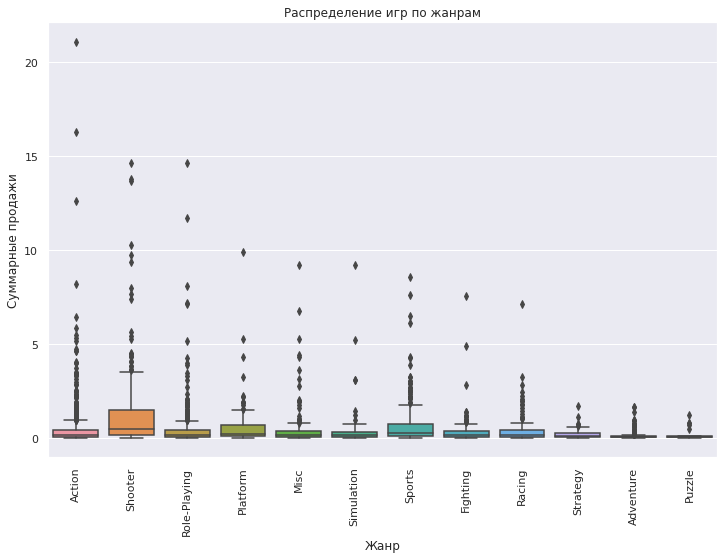

In [42]:
# Создадим сначала график, чтобы посмотреть на количество выбросов в целом
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='total_sales', data=period)

plt.xticks(rotation=90)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи')

plt.show()

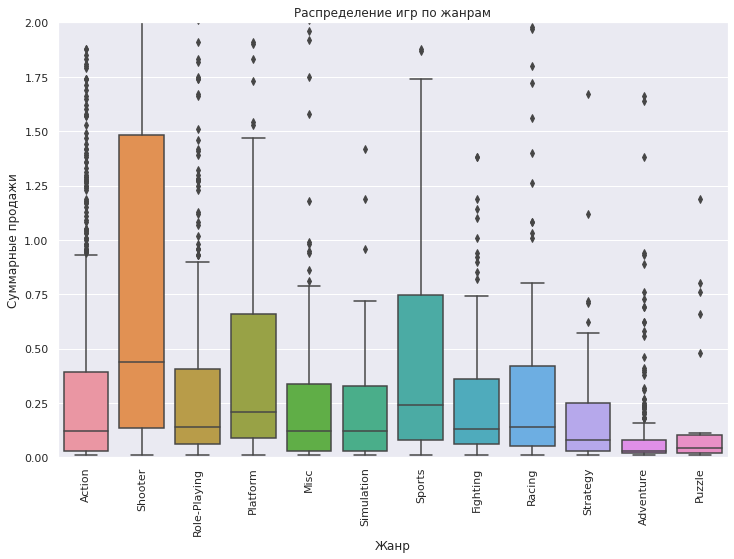

In [43]:
# Теперь создадим график, чтобы посмотреть на медианные значения:
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='total_sales', data=period)

plt.xticks(rotation=90)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи')
plt.ylim(0, 2)

plt.show()

**Вывод:**
* Мы видим, что медиана у жанра **Shooter** находится выше, чем у остальных жанров, но полностью сказать, что это это самый популярный и прибыльный жанр - нельзя. Всё потому, что размах ящика у этого жанра очень широкий, это нам говорит о нестабильности шутера. Также, если мы посмотрим на выбросы, а их очень много, то это лишь подтверждает нерегулярные успехи жанра.

* Самое большое количество выбросов у жанра **Action**, это тоже знак нестабильности. По уровню медианы и размаха можно сказать, что не самый успешно продаваемый жанр, но он не отстаёт от остальных.

* Глядя на жанр игр **Platform** и **Srorts**, мы видим примерно одинаковое медианное значение продаж, меньше, чем у жанра шутер, также небольшой размах ящика, а по сравнению с жанром экшен, небольшое количество выбросов. Можно сказать, что эти жанры не совсем имеют стабильные продажи, но они стремятся к этому.

* **Role-Playing, Misc** можно сравнивать тоже вместе, так как их медианные продажи на примерно одинаковом уровне (меньше, чем у жанра шутер). Эти жанры имею достаточное количество выбросов (но меньше, чем у жанра экшен), что намекает на нестабильность продаж.

* Жанры - **Fighting, Simulation, Racing** по сравнению с предыдущими жанрами видеоигр имеют меньшее количество выбросов, но и меньшее медианное значение продаж, поэтому мы можем предположить, что это непопулярные жанры, но у них есть своя небольшая аудитория, которая стабильно их приобретает.

* Наименьшие медианные продажи у жанров **Strategy**, **Adventure** и **Puzzle**, но у них наблюдается стабильность, в отличие от всех остальных жанров. Это нам говорит о том, что их продают регулярно, но мало, видимо есть небольшая группа любителей именно этих жанров.  

#### Краткий вывод по исследовательскому анализу данных:

* До **1991** года выпускалось **малое количество**. В **1998** году видно **скачок** по количеству выпускаемых игр. **2008-2009** года являются **пиками роста** выпускаемых игр. С **2010** и далее происходит **спад** выпускаемых видеоигр, можно предположить, что причиной этого могло послужить развитие мобильных устройств.
* Выделили 5 самых популярных платформ (**PS2, X360, PS3, Wii, DS**), выяснили, что средний срок их существования примерно **10 лет**.
* Мы выбрали актуальный период - с **2012 по 2016**. Платформы: **PS4, 3DS, XOne, WiiU, PC, PSV** мы выяснили, что являются потенциально прибыльными, так как к 2016 они, в отличие отостальных, ещё хорошо продавались на рынке. 
* Выяснили, что по медианным значениям продажи больше всего у платформы **XOne и Wii**, далее - **PS4, 3DS,**, а на предпоследнем и последнем местах - **PC и PSV** соотвветственно. 
* У **PS4, 3DS, Xbox One, WiiU** наблюдается в какой-то степени связь между оценками критиков и продажами. Связь между оценками пользователей и продажами слабая у всех платформ, либо её вовсе нет. Только у **WiiU** корреляция между отзывами пользователей и продажами нормальная и даже больше, чем корреляция между отзывами критиков и игровой платформой. Следовательно, покупатели прислушиваются больше к критикам, нежели к оценкам других пользователей. Но на платформе **WiiU** наоборот.
* Медианное значение продаж выше всего у жанра Shooter, но это самый не стабильный жанр видео игр. Но, если наши приоритеты расставленны на доходность, то это хороший вариант. Если мы хотим стабильность, но при небольшом доходе, то нам отлично подойдут такие жанры: **Fighting, Simulation, Racing, Strategy, Adventure и Puzzle**. Если искать такие жанры, которые будут приносить средний доход, а также будут иметь среднюю стабильность, то стоит выбирать между **Platform, Srorts, Role-Playing и Misc**.

### Составим портрет пользователя каждого региона (NA, EU, JP).

#### Самые популярные платформы регионов (топ-5). 

In [44]:
# Создадим таблицу, которая сортирует топ-5 платформ в регионе North America:
top_platforms_na = period.pivot_table(index='platform',
                                    values='na_sales', 
                                    aggfunc='sum').sort_values(by='na_sales', ascending=False)
top_platforms_na = top_platforms_na.head().reset_index()

# Создадим таблицу, которая сортирует топ-5 платформ в регионе Europe:
top_platforms_eu = period.pivot_table(index='platform',
                                    values='eu_sales', 
                                    aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_platforms_eu = top_platforms_eu.head().reset_index()

# Создадим таблицу, которая сортирует топ-5 платформ в регионе Japan:
top_platforms_jp = period.pivot_table(index='platform',
                                    values='jp_sales', 
                                    aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_platforms_jp = top_platforms_jp.head().reset_index()

display(top_platforms_na, top_platforms_eu, top_platforms_jp)

,platform,na_sales
0,X360,140.050003
1,PS4,108.739998
2,PS3,103.379997
3,XOne,93.120003
4,3DS,55.310001


,platform,eu_sales
0,PS4,141.089996
1,PS3,106.849998
2,X360,74.519997
3,XOne,51.590000
4,3DS,42.639999


,platform,jp_sales
0,3DS,87.790001
1,PS3,35.290001
2,PSV,21.039999
3,PS4,15.960000
4,WiiU,13.010000


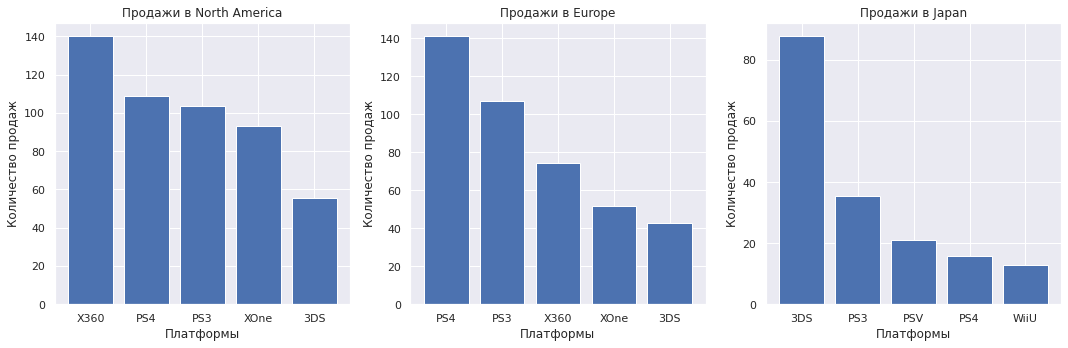

In [45]:
# Визуализируем эти данные:
plt.figure(figsize=(15, 5)) 

# Диаграмма 1
plt.subplot(131)
plt.bar(top_platforms_na['platform'], top_platforms_na['na_sales'])
plt.title('Продажи в North America')
plt.xlabel('Платформы')
plt.ylabel('Количество продаж')

# Диаграмма 2
plt.subplot(132)
plt.bar(top_platforms_eu['platform'], top_platforms_eu['eu_sales'])
plt.title('Продажи в Europe')
plt.xlabel('Платформы')
plt.ylabel('Количество продаж')

# Диаграмма 3
plt.subplot(133)
plt.bar(top_platforms_jp['platform'], top_platforms_jp['jp_sales'])
plt.title('Продажи в Japan')
plt.xlabel('Платформы')
plt.ylabel('Количество продаж')

plt.tight_layout() 
plt.show()  


Вывод по топ-5 популярным платформы регионов:
* В Северной Америке самые популярные платформы: X360, PS4, PS3, XOne, 3DS.
* В Европе популярны PS4, PS3, X360, XOne, 3DS.
* В Японии на первом месте - 3DS, далее PS3, PSV, PS4, WiiU.

#### Самые популярные жанры (топ-5). Поясните разницу.

In [46]:
# Создадим таблицу, которая сортирует топ-5 жанров в регионе North America:
top_genre_na = period.pivot_table(index='genre',
                                    values='na_sales', 
                                    aggfunc='sum').sort_values(by='na_sales', ascending=False)
top_genre_na = top_genre_na.head().reset_index()

# Создадим таблицу, которая сортирует топ-5 жанров в регионе Europe:
top_genre_eu = period.pivot_table(index='genre',
                                    values='eu_sales', 
                                    aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_genre_eu = top_genre_eu.head().reset_index()

# Создадим таблицу, которая сортирует топ-5 жанров в регионе Japan:
top_genre_jp = period.pivot_table(index='genre',
                                    values='jp_sales', 
                                    aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_genre_jp = top_genre_jp.head().reset_index()

display(top_genre_na, top_genre_eu, top_genre_jp)

,genre,na_sales
0,Action,177.839996
1,Shooter,144.770004
2,Sports,81.529999
3,Role-Playing,64.000000
4,Misc,38.189999


,genre,eu_sales
0,Action,159.339996
1,Shooter,113.470001
2,Sports,69.080002
3,Role-Playing,48.529999
4,Racing,27.290001


,genre,jp_sales
0,Role-Playing,65.440002
1,Action,52.799999
2,Misc,12.860000
3,Simulation,10.410000
4,Fighting,9.440000


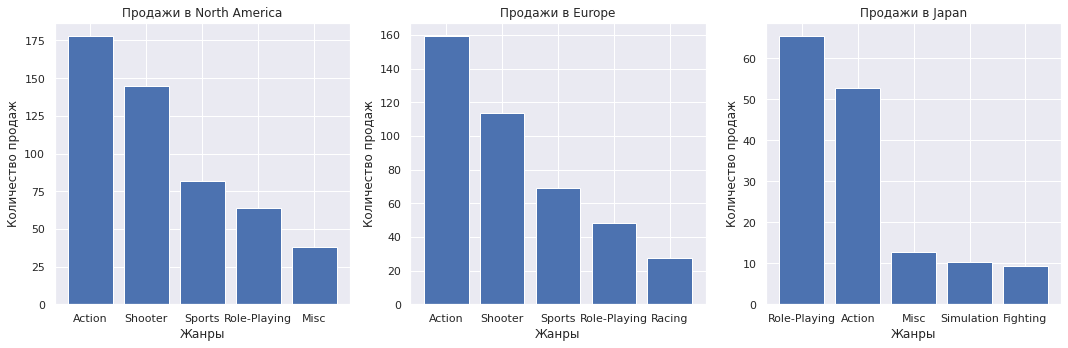

In [47]:
# Визуализируем эти данные:
plt.figure(figsize=(15, 5)) 

# Диаграмма 1
plt.subplot(131)
plt.bar(top_genre_na['genre'], top_genre_na['na_sales'])
plt.title('Продажи в North America')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')

# Диаграмма 2
plt.subplot(132)
plt.bar(top_genre_eu['genre'], top_genre_eu['eu_sales'])
plt.title('Продажи в Europe')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')

# Диаграмма 3
plt.subplot(133)
plt.bar(top_genre_jp['genre'], top_genre_jp['jp_sales'])
plt.title('Продажи в Japan')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')

plt.tight_layout()  
plt.show()  

Вывод по топ-5 популярным жанрам игр регионов:
* В Северной Америке самые популярные жанры видеоигр: Action, Shooter, Sports, Role-Playing, Misc.
* В Европе почти такой же набор самых популярных жанров: Action, Shooter, Sports, Role-Playing, Racing.
* В Японии на первом месте - Role-Playing, далее Action, Misc, Simulation, Fighting.

Мы видим, что у Северной Америки и Европы почти одинаковые предпочтения в жанрах видеоигр. Люди в там любят экшен, шутер и спортивные жанры игр.

В Японии совершенно другой набор - больше всего любят ролевые игры.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Описание: 
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»

In [48]:
# Создадим таблицу, которая сортирует топ-5 жанров в регионе North America:
top_rating_na = period.pivot_table(index='rating',
                                    values='na_sales', 
                                    aggfunc='sum').sort_values(by='na_sales', ascending=False)
top_rating_na = top_rating_na.head().reset_index()

# Создадим таблицу, которая сортирует топ-5 жанров в регионе Europe:
top_rating_eu = period.pivot_table(index='rating',
                                    values='eu_sales', 
                                    aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_rating_eu = top_rating_eu.head().reset_index()

# Создадим таблицу, которая сортирует топ-5 жанров в регионе Japan:
top_rating_jp = period.pivot_table(index='rating',
                                    values='jp_sales', 
                                    aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_rating_jp = top_rating_jp.head().reset_index()

display(top_rating_na, top_rating_eu, top_rating_jp)

,rating,na_sales
0,M,231.569992
1,E,114.370003
2,Unknown,103.309998
3,E10+,75.699997
4,T,66.019997


,rating,eu_sales
0,M,193.960007
1,E,113.019997
2,Unknown,91.500000
3,E10+,55.369999
4,T,52.959999


,rating,jp_sales
0,Unknown,108.839996
1,E,28.330000
2,T,26.020000
3,M,21.200001
4,E10+,8.190000


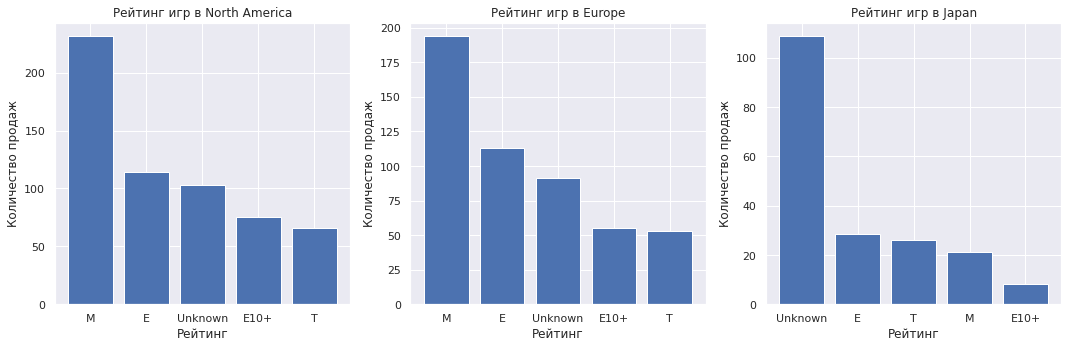

In [49]:
# Визуализируем эти данные:
plt.figure(figsize=(15, 5)) 

# Диаграмма 1
plt.subplot(131)
plt.bar(top_rating_na['rating'], top_rating_na['na_sales'])
plt.title('Рейтинг игр в North America')
plt.xlabel('Рейтинг')
plt.ylabel('Количество продаж')

# Диаграмма 2
plt.subplot(132)
plt.bar(top_rating_eu['rating'], top_rating_eu['eu_sales'])
plt.title('Рейтинг игр в Europe')
plt.xlabel('Рейтинг')
plt.ylabel('Количество продаж')

# Диаграмма 3
plt.subplot(133)
plt.bar(top_rating_jp['rating'], top_rating_jp['jp_sales'])
plt.title('Рейтинг игр в Japan')
plt.xlabel('Рейтинг')
plt.ylabel('Количество продаж')

plt.tight_layout()  
plt.show()

Вывод рейтингов видеоигр от организации ESRB по разным регионам:
* Северная Америка и Европа снова схожи: на первом месте по продажами игры с рейтингом - «Для взрослых» (M), далее игры «Для всех» (E), «Unknown» (Игры без рейтинга) и «Для всех от 10 лет и старше» (E10+), на последнем месте - «Подросткам» (T)
* В Японии рейтинг немного другой, больше продаж по играм без рейтинга - «Unknown», далее идут «Для всех» (E), дальше рейтинг у игр «Подросткам» (T), «Для взрослых» (M) и на последнем месте «Для всех от 10 лет и старше» (E10+).

#### Портрет пользователя в Северной Америке:

- В Северной Америке самые популярные платформы: X360, PS4, PS3, XOne, 3DS. Жанры, которые чаще всего выбирают пользователи - Action, Shooter, Sports, Role-Playing, Misc. Больше всего продаж у игр с рейтингом «Для взрослых» (M), далее игры «Для всех» (E), «Unknown» (Игры без рейтинга) и «Для всех от 10 лет и старше» (E10+), на последнем месте - «Подросткам» (T)

- В Европе топ-5 платформ: PS4, PS3, X360, XOne, 3DS. В Европе почти такой же набор, как и в Америке, самых популярных жанров: Action, Shooter, Sports, Role-Playing, Racing. Набор популярных игр по рейтингам совпадает с Америкой. 

- В Японии на первом месте игровая платформа 3DS, далее PS3, PSV, PS4, WiiU. Популярный жанр видеоигр - Role-Playing, далее Action, Misc, Simulation, Fighting. Больше продаж у игр с рейтингом «Unknown» (Игры без рейтинга), затем игры - «Для всех» (E), дальше рейтинг у игр «Подросткам» (T), «Для взрослых» (M) и на последнем месте «Для всех от 10 лет и старше» (E10+).

### Проверим некоторые гипотезы.

####  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Для проверки гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC сформулируем нулевую и альтернативную гипотезы:

**Нулевая гипотеза**: Средние пользовательские рейтинги платформ Xbox One и PC равны.

**Альтернативная гипотеза**: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Для проверки этих гипотез можно использовать t-тест для независимых выборок, так как мы сравниваем две разные платформы (Xbox One и PC) и у нас есть две независимые выборки пользовательских рейтингов для каждой платформы.

In [50]:
# Выделим пользовательские рейтинги для Xbox One и PC, также удалим пропущенные значения в этих столбцах:
xbox_one_scores = period[period['platform'] == 'XOne']['user_score'].dropna() 
pc_scores = period[period['platform'] == 'PC']['user_score'].dropna() 

# Проводим t-тест:
results = st.ttest_ind(xbox_one_scores, pc_scores, alternative='two-sided', equal_var=True)

# Задаем уровень статистической значимости:
alpha = 0.05

# Выводим результаты t-теста
print('p-значение:', results.pvalue)

# Проверяем гипотезу:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC различаются.")
else:
    print("Не отвергаем нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC равны.")

print(f"Средний пользовательский рейтинг для платформы Xbox One: {xbox_one_scores.mean()}")
print(f"Средний пользовательский рейтинг для платформы PC: {pc_scores.mean()}")

p-значение: 0.5535102819461235
Не отвергаем нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC равны.
Средний пользовательский рейтинг для платформы Xbox One: 6.521428108215332
Средний пользовательский рейтинг для платформы PC: 6.428640842437744


Полученное значение p-value ~ 0.55 больше заданного уровня значимости. Следовательно, мы не можем отвергнуть нулевую гипотезу и считаем, что средние пользовательские рейтинги равны.

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверки гипотезы о различии средних пользовательских рейтингов жанров Action и Sports можно сформулировать нулевую и альтернативную гипотезы следующим образом:

**Нулевая гипотеза**: Средние пользовательские рейтинги жанров Action и Sports одинаковы.

**Альтернативная гипотеза**: Средние пользовательские рейтинги жанров Action и Sports различаются.

Для проверки этих гипотез можно использовать t-тест для независимых выборок, так как мы сравниваем два разных жанра (Action и Sports) и у нас есть две независимые выборки пользовательских рейтингов для каждого жанра.

In [51]:
# Выделяем пользовательские рейтинги для жанра Action и Sports, также удалим пропущенные значения в этих столбцах:
action_scores = period[period['genre'] == 'Action']['user_score'].dropna()
sports_scores = period[period['genre'] == 'Sports']['user_score'].dropna()

# Проводим t-тест
t_statistic, p_value = st.ttest_ind(action_scores, sports_scores, alternative='two-sided', equal_var=False)

# Задаем уровень значимости
alpha = 0.05

# Выводим результаты t-теста
print(f"p-значение: {p_value}")

# Проверяем гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports различаются.")
else:
    print("Не отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports одинаковы.")

print(f"Средний пользовательский рейтинг для жанра Action: {action_scores.mean()}")
print(f"Средний пользовательский рейтинг для жанра Sports: {sports_scores.mean()}")


p-значение: 5.989172574568752e-20
Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports различаются.
Средний пользовательский рейтинг для жанра Action: 6.825047969818115
Средний пользовательский рейтинг для жанра Sports: 5.455669403076172


Полученное значение p-value ~ 4.24*10^-20 меньше заданного уровня значимости. Следовательно, мы можем сказать, что средние пользовательские рейтинги различаются. 

### Общий вывод.

Мы провели работу с данными интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Рассмотрели данные о продажах игр, об оценках пользователей и экспертов, о жанрах и платформах.

**1) Загрузка данных.**
На этом этапе мы изучили информацию, ознакомились с общими данными в датасете, обнаружили отсутствие данных и несоответствие типов данных.

**2) Предобработка данных.**
* Привели названия столбцов к нижнему регистру. 
* **Пропуски:** 
    - Для столбцов "name" и "genre" удаляем пропуски. Эти пропуски возникли, вероятно, из-за сложности названий игр или незнания жанра. 
    - Пропуски в столбце "year_of_release" также были удалены, их было 269 (1,6% от всего объема данных). Это могло произойти из-за незнания года выпуска игры или из-за забвения. 
    - Пропуски в столбцах "user_score" (6607) и "critic_score" (8463) остались без изменений, так как нет логической замены для них. 
    - А вот пропуски в столбце "rating" (6678) мы заменили на «Unknown» (Игры без рейтинга). Так как система рейтинга ESRB была основана в 1994 году, скорее всего, именно поээтому есть игры, которые не оценены.

* Значения "tbd" были заменены на NaN. 
* Мы добавили столбец "total_sales", содержащий сумму продаж по всем регионам для каждой игры. 
* **Замена типа данных:**
    - Столбец "year_of_release" был преобразован в целочисленный тип данных Int64.
    - Тип данных столбца "user_score" был изменен с object на float32. 
    - Для экономии памяти типы данных float64 были заменены на float32. 
* **Проверка дубликатов:**
    - Проработали явные и неявные дубликаты, первых не обнаружилось. 
    - Неявных дубликатов выявили только одну пару, это две строки (одинаковое в этих строках всё, кроме количества продаж в регионах), одну из строк, которая несла в себе мало информации, я удалила.

По итогу предобработки у нас осталось **16443**  строки - это **98,4%** от общего объёма данных (**16715** строк).

**3) Исследовательский анализ данных.**
* Мы посмотрели сколько игры выпускалось в разные годы:
    - До 1991 года выпускалось небольшое количество видеоигр. 
    - Однако в 1998 году наблюдается резкий рост в числе выпускаемых игр. 
    - Пиком по количеству выпущенных игр стали годы 2008-2009. 
    - Начиная с 2010 года, мы видим снижение объема выпускаемых видеоигр, что может быть связано с развитием мобильных устройств.

* Мы выделили 5 наиболее популярных игровых платформ (PS2, X360, PS3, Wii, DS) и установили, что средний срок их существования составляет примерно **10 лет**.

* Для анализа выбрали актуальный период с **2012 по 2016** год. В этот период в качестве **потенциально прибыльных платформ выделили PS4, 3DS, XOne, WiiU, PC и PSV,** так как они продолжали успешно продаваться на рынке к **2016 году**, в отличие от других.

* Медианные значения продаж показали, что **самыми успешными платформами являются **XOne и Wii**, затем идет **PS4, 3DS**, на предпоследнем и последнем местах - **PC и PSV** соотвветственно.

* Посмотрели также на то, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков:
    - На PS4, 3DS, Xbox One и WiiU можно заметить некоторую связь между оценками критиков и объемами продаж. 
    - Однако связь между оценками пользователей и продажами слаба или вовсе отсутствует у всех платформ, кроме WiiU, где корреляция между оценками пользователей и продажами даже превышает корреляцию между оценками критиков и продажами. 
    - **Следовательно, для большинства платформ покупатели больше доверяют мнению критиков, чем оценкам других пользователей, но это не относится к WiiU.**

* Выделили жанры которые могут быть прибыльными и те, которые имеют стабильность: 
    - Медианное значение продаж выше всего у жанра **Shooter**, но это самый не стабильный жанр видео игр. Но, если наши приоритеты расставленны на доходность, то это хороший вариант. 
    - Если мы хотим стабильность, но при небольшом доходе, то нам отлично подойдут такие жанры: **Fighting, Simulation, Racing, Strategy, Adventure и Puzzle**. 
    - Если искать такие жанры, которые будут приносить средний доход, а также будут иметь среднюю стабильность, то стоит выбирать между **Platform, Srorts, Role-Playing и Misc**.

**4) Составление портрета пользователя каждого региона.**

В **Северной Америке** пятерка самых популярных платформ включает в себя **X360, PS4, PS3, XOne и 3DS**. Что касается предпочтительных жанров среди пользователей, то здесь лидируют **Action, Shooter, Sports, Role-Playing и Misc**. Важно отметить, что игры с рейтингом **«Для взрослых» (M)** имеют наибольшие продажи, за ними следуют игры с рейтингом **«Для всех» (E)**, **«Unknown» (Игры без рейтинга)** и **«Для всех от 10 лет и старше» (E10+)**, а наименьшие продажи у игр с рейтингом **«Подросткам» (T)**.

В **Европе** топ-5 платформ похож на американский: **PS4, PS3, X360, XOne и 3DS**. Предпочтения по жанрам также схожи с Америкой: **Action, Shooter, Sports, Role-Playing и Racing** наиболее популярны. Аналогично, популярные игры по рейтингу совпадают с выбором в Америке.

В **Японии** ситуация отличается. Топ-5 платформ включает **3DS, PS3, PSV, PS4 и WiiU**. Самым популярным жанром является **Role-Playing**, за ним идут **Action, Misc, Simulation** и **Fighting**. В Японии игры с рейтингом **«Unknown» (Игры без рейтинга)** имеют наибольшие продажи, за ними следуют игры с рейтингом **«Для всех» (E)**, **«Подросткам» (T)**, **«Для взрослых» (M)** и на последнем месте игры с рейтингом **«Для всех от 10 лет и старше» (E10+)**.

**5) Проверка гипотез**
1. Средние пользовательские рейтинги платформ Xbox One и PC равны.
- Не получилось отвергнуть нулевую гипотезу, поэтому считаем, что средние пользовательские рейтинги равны.
2. Средние пользовательские рейтинги жанров Action и Sports одинаковы.
- Отвергаем нулевую гипотезу, следовательно, средние пользовательские рейтинги жанров Action и Sports различаются.

**Теперь разберём главный шаг исследования** - выявление закономерностей, которые определяют успешность игры. Это нам позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

* Выбор **платформы** играет решающую роль в успехе игры. Наиболее популярные платформы различаются в зависимости от региона. В Северной Америке и Европе популярны PS4 и XOne, а в Японии - 3DS. Поэтому разработчики должны адаптировать свои игры под платформы, доминирующие в конкретном регионе.

* **Жанр игры** также оказывает существенное влияние на ее успех. Жанры Action, Shooter, Sports и Role-Playing обычно имеют высокие продажи в разных регионах. Разработка игр в этих жанрах может быть более прибыльной.

* **Рейтинг ESRB** влияет на продажи в зависимости от региона. В Северной Америке и Европе игры с рейтингом "Для взрослых" (M) часто успешны, в то время как в Японии игры с рейтингом "Для всех" (E) популярны. Поэтому важно выбирать соответствующий рейтинг для целевой аудитории.

* **Оценки критиков и пользователей** имеют какое-то влияние на продажи игр на некоторых платформах, таких как PS4, 3DS, Xbox One и WiiU. Учитывая это, разработчики могут стремиться к получению хороших оценок.

* Для планирования на **2017 год** можно рассмотреть платформы **PS4, 3DS, XOne, WiiU, PC и PSV** как потенциально прибыльные, так как они успешно продавались к 2016 году. Жанры **Action, Shooter, Sports и Role-Playing** также остаются популярными.

**Исходя из этих закономерностей, разработчики могут прогнозировать успешность своих игр, выбирать подходящие платформы и жанры, а также адаптировать рейтинг и маркетинговые стратегии для конкретных регионов.**